Hello fellow Kagglers,

This notebook demonstrates the inference process using an EfficientNetV2T model training on a TPU.

The inference process consists of 2 steps.

1) Preprocess and save all images in parallel, images are cropped, padded to correct aspect ratio and resized to the target size.

2) Prediction on preprocessed images in a simple loop, final cancer score is mean of all images.

**V3**

* Switch to ConvNextV2 models

**V6**

This will be the final update of my notebooks for this competitions, which should achieve a LB score in the low 0.50s. I will continue participating in this competition, however, I will not share my progress anymore.

* Mainly updated preprocessing procedure, see examples under Example Preprocessing.
* Correct linear/sigmoid normalization of images, many thanks to [Bob de Graaf](https://www.kaggle.com/bobdegraaf) which shared this amazing notebook: [DicomSDL & VOI-LUT](https://www.kaggle.com/code/bobdegraaf/dicomsdl-voi-lut)
* Inference should be faster now due to actually using dicomsdl and not just installing it...

**Training Notebook:** [RSNA ConvNextV2 Training Tensorflow TPU](https://www.kaggle.com/code/markwijkhuizen/rsna-efficientnetv2-training-tensorflow-tpu/notebook)

**Data Preprocessing Notebook:** [RSNA Cropped TFRecords 768x1344 Dataset](https://www.kaggle.com/code/markwijkhuizen/rsna-cropped-tfrecords-768x1344-dataset/notebook)


Good luck to all of you in the last month of this excisting competition!

In [1]:
%%capture
# Source: https://www.kaggle.com/code/remekkinas/fast-dicom-processing-1-6-2x-faster?scriptVersionId=113360473
!pip install /kaggle/input/rsnamodules/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

try:
    import pylibjpeg
except:
   !pip install /kaggle/input/rsna-2022-whl/{pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [2]:
# Install Keras CV Attention Model Pip Package for ConvNextV2 Models
!pip install --no-deps /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.5-py3-none-any.whl

Processing /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.5-py3-none-any.whl


In [3]:
import numpy as np
import pandas as pd
import pylibjpeg
import pydicom
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from keras_cv_attention_models import convnext

import cv2
import glob
import importlib
import os
import joblib
import time
import dicomsdl
import gc

# Tensorflow and CV2 set number of threads to 1 for speedup in parallell function mapping
tf.config.threading.set_inter_op_parallelism_threads(num_threads=1)
cv2.setNumThreads(1)

# Pandas DataFrame Display Options
pd.options.display.max_colwidth = 99

# Config

In [4]:
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

TARGET_HEIGHT = 1344
TARGET_WIDTH = 768
N_CHANNELS = 1
INPUT_SHAPE = (TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS)
TARGET_HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH
THRESHOLD_BEST = 0.50

CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False

IMAGE_FORMAT = 'jpg'

# VOI LUT

In [5]:
# Source: https://www.kaggle.com/code/bobdegraaf/dicomsdl-voi-lut
def voi_lut(image, dicom):
    # Additional Checks
    if 'WindowWidth' not in dicom.getPixelDataInfo() or 'WindowWidth' not in dicom.getPixelDataInfo():
        return image
    
    # Load only the variables we need
    center = dicom['WindowCenter']
    width = dicom['WindowWidth']
    bits_stored = dicom['BitsStored']
    voi_lut_function = dicom['VOILUTFunction']

    # For sigmoid it's a list, otherwise a single value
    if isinstance(center, list):
        center = center[0]
    if isinstance(width, list):
        width = width[0]

    # Set y_min, max & range
    y_min = 0
    y_max = float(2**bits_stored - 1)
    y_range = y_max

    # Function with default LINEAR (so for Nan, it will use linear)
    if voi_lut_function == 'SIGMOID':
        image = y_range / (1 + np.exp(-4 * (image - center) / width)) + y_min
    else:
        # Checks width for < 1 (in our case not necessary, always >= 750)
        center -= 0.5
        width -= 1

        below = image <= (center - width / 2)
        above = image > (center + width / 2)
        between = np.logical_and(~below, ~above)

        image[below] = y_min
        image[above] = y_max
        if between.any():
            image[between] = (
                ((image[between] - center) / width + 0.5) * y_range + y_min
            )

    return image

# Crop Image

In [6]:
# Smooth vector used to smoothen sums/stds of axes
def smooth(l):
    # kernel size is 1% of vector
    kernel_size = int(len(l) * 0.01)
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(l, kernel, mode='same')

# X Crop offset based on first column with sum below 5% of maximum column sums*std
def get_x_offset(image, max_col_sum_ratio_threshold=0.05, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Percentual margin added to offset
    margin = int(image.shape[1] * 0.00)
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=0).squeeze()) * smooth(image.std(axis=0).squeeze())
    # Find maximum sum in first 75% of columns
    vv_argmax = vv[:int(image.shape[1] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_col_sum_ratio_threshold
    
    # Find first column after maximum column below threshold value
    for offset, v in enumerate(vv):
        # Start searching from vv_argmax
        if offset < vv_argmax:
            continue
        
        # Column below threshold value found
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
            
    if isinstance(debug, np.ndarray):
        debug[1].imshow(image)
        debug[1].set_title('X Offset')
        vv_scale = H / vv.max() * 0.90
        # Values
        debug[1].plot(H - vv * vv_scale , c='red', label='vv')
        # Threshold
        debug[1].hlines(H - vv_threshold * vv_scale, 0, W -1, colors='orange', label='threshold')
        # Max Value
        debug[1].scatter(vv_argmax, H - vv[vv_argmax] * vv_scale, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[1].scatter(offset, H - vv[offset] * vv_scale, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[1].set_ylim(H, 0)
        debug[1].legend()
        debug[1].axis('off')
        
    return offset

# Y Crop offset based on first bottom and top rows with sum below 10% of maximum row sum*std
def get_y_offsets(image, max_row_sum_ratio_threshold=0.10, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Margin to add to offsets
    margin = 0
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=1).squeeze()) * smooth(image.std(axis=1).squeeze())
    # Find maximum sum * std row in inter quartile rows
    vv_argmax = int(image.shape[0] * 0.25) + vv[int(image.shape[0] * 0.25):int(image.shape[0] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_row_sum_ratio_threshold
    # Default crop offsets
    offset_bottom = 0
    offset_top = H

    # Bottom offset, search from argmax to bottom
    for offset in reversed(range(0, vv_argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
    
    if isinstance(debug, np.ndarray):
        debug[2].imshow(image)
        debug[2].set_title('Y Bottom Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[2].plot(vv * vv_scale, np.arange(H), c='red', label='vv')
        # Threshold
        debug[2].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[2].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[2].scatter(vv[offset_bottom] * vv_scale, offset_bottom, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[2].legend()
        debug[2].axis('off')
            
    # Top offset, search from argmax to top
    for offset in range(vv_argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug, np.ndarray):
        debug[3].imshow(image)
        debug[3].set_title('Y Top Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[3].plot(vv * vv_scale, np.arange(H) , c='red', label='vv')
        # Threshold
        debug[3].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[3].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[3].scatter(vv[offset_top] * vv_scale, offset_top, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[3].legend()
        debug[3].axis('off')
            
    return max(0, offset_bottom - margin), min(image.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop(image, size=None, debug=False):
    # Image dimensions
    H, W = image.shape
    # Compute x/bottom/top offsets
    x_offset = get_x_offset(image, debug=debug)
    offset_bottom, offset_top = get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop Image
    image = image[offset_bottom:offset_top:,:x_offset]
        
    return image

# Process Image

In [7]:
def process(file_path, size=(TARGET_WIDTH, TARGET_HEIGHT), crop_image=CROP_IMAGE, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False, save=True):
    # Read Dicom File
    dicom = dicomsdl.open(file_path)
    image = dicom.pixelData()
    
    # Save original image for debug purposes
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
    
    # voi_lut
    try:
        image = voi_lut(image, dicom)
    except:
        pass
    
    # Some images have 0 values as highest intensity and need to be inverted
    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == 'MONOCHROME1':
        image = np.max(image) - image

    # Normalize [0,1] range
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to uint8 image in range [0, 255]
    image = (image * 255).astype(np.uint8)
    
    # Flip T0 Left/Right Orientation
    h0, w0 = image.shape
    if image[:,int(-w0 * 0.10):].sum() > image[:,:int(w0 * 0.10)].sum():
        image = np.flip(image, axis=1)
    
    # Crop Image
    if crop_image:
        image = crop(image, debug=axes)
        
    # Resize
    if size is not None:
        # Pad black pixels to make square image
        h, w = image.shape
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image = np.pad(image, [[0,0], [0, pad]])
            h, w = image.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image = np.pad(image, [[pad, pad], [0,0]])
            h, w = image.shape
        # Resize
        image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
    # Apply CLAHE contrast enhancement
    if apply_clahe:
        image = CLAHE.apply(image)
        
     # Apply Histogram Equalization
    if apply_eq_hist:
        image = cv2.equalizeHist(image)
        
    # Show Processed Image    
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()
        
    # Save Only
    if save:
        image_id = file_path.split('/')[-1].split('.')[0]
        if IMAGE_FORMAT == 'png':
            cv2.imwrite(f'{image_id}.png', image)
        else:
            cv2.imwrite(f'{image_id}.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 95])

# Example Preprocessing

In [8]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
    
def get_file_path(args):
    patient_id, image_id = args
    return f'/kaggle/input/rsna-breast-cancer-detection/train_images/{patient_id}/{image_id}.dcm'
    
train['file_path'] = train[['patient_id', 'image_id']].apply(get_file_path, axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

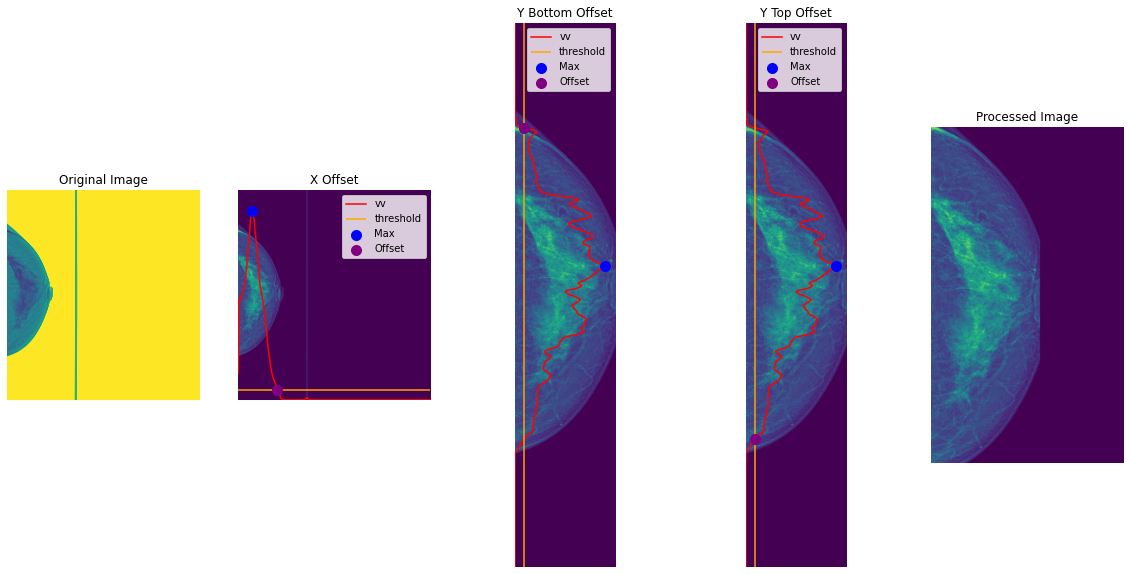

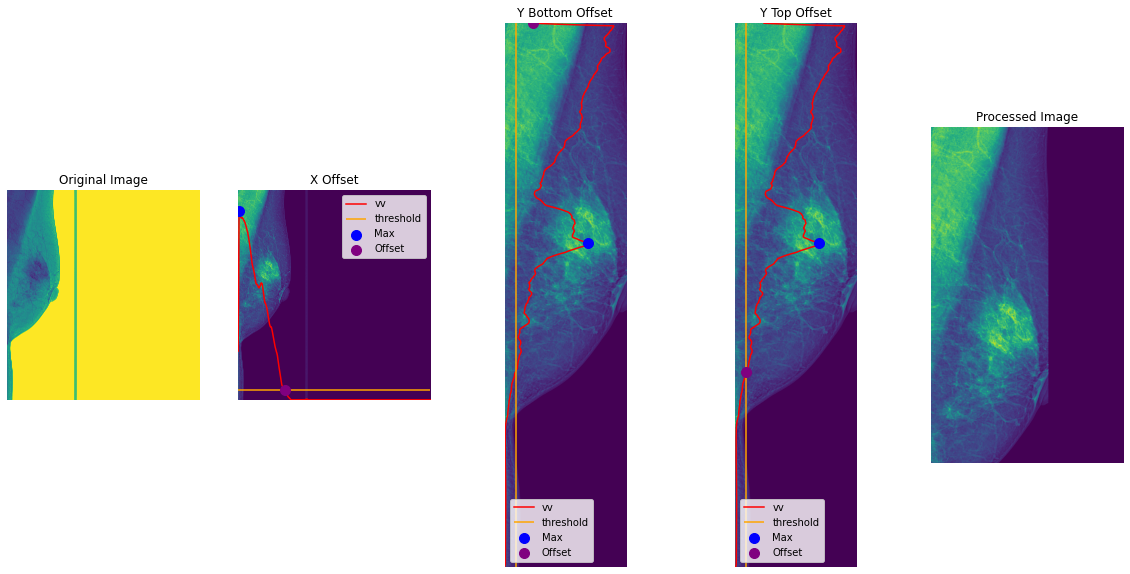

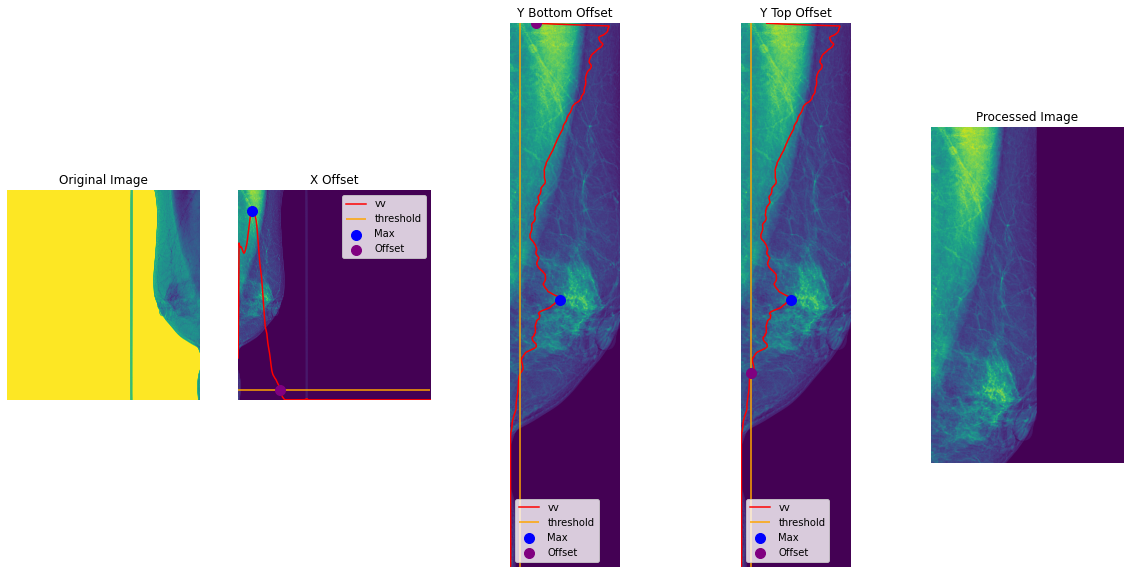

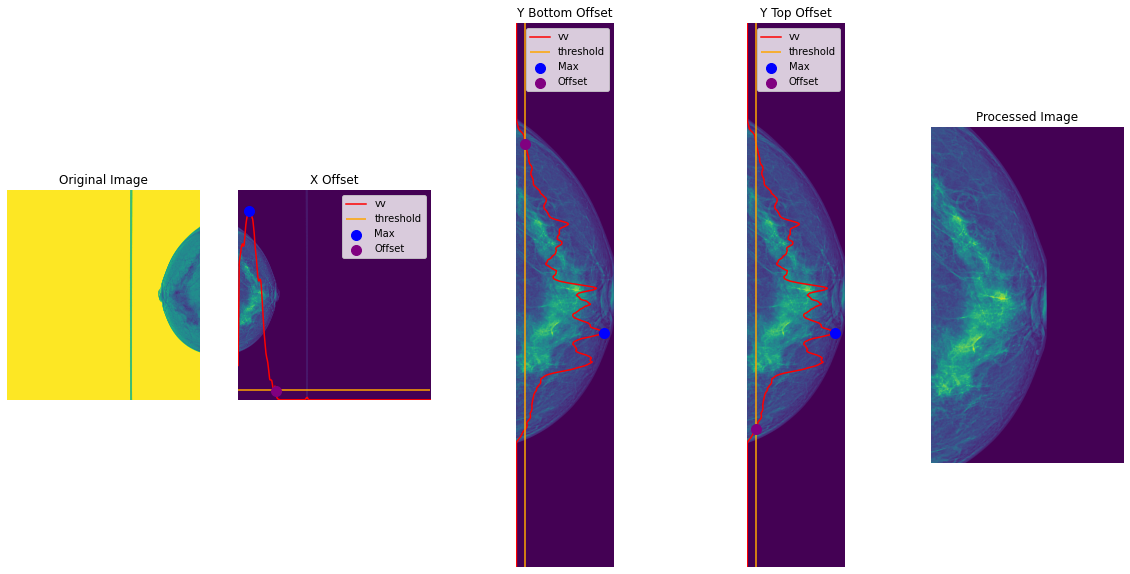

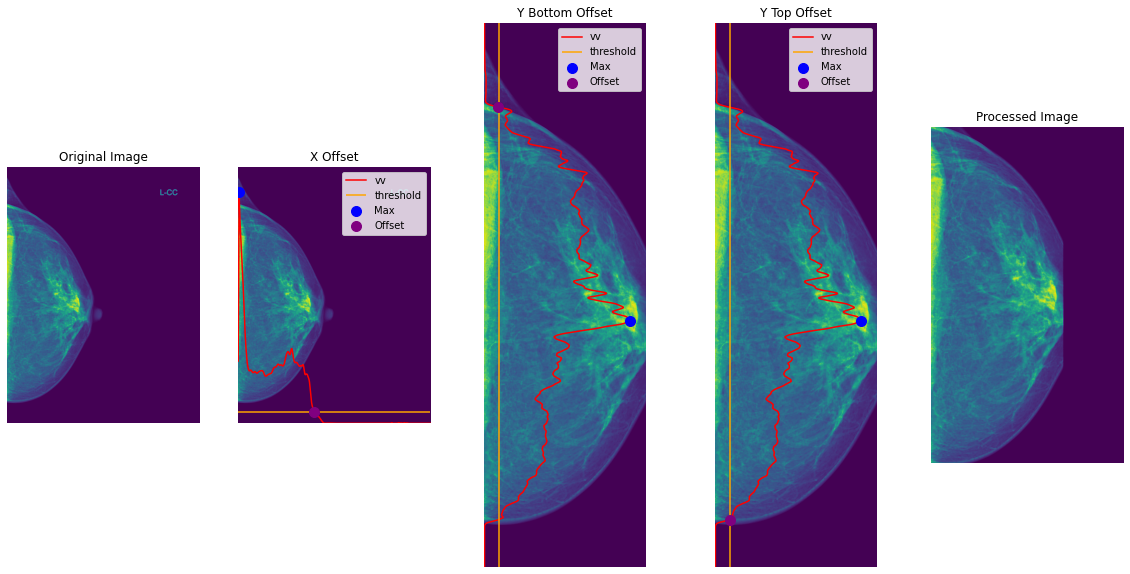

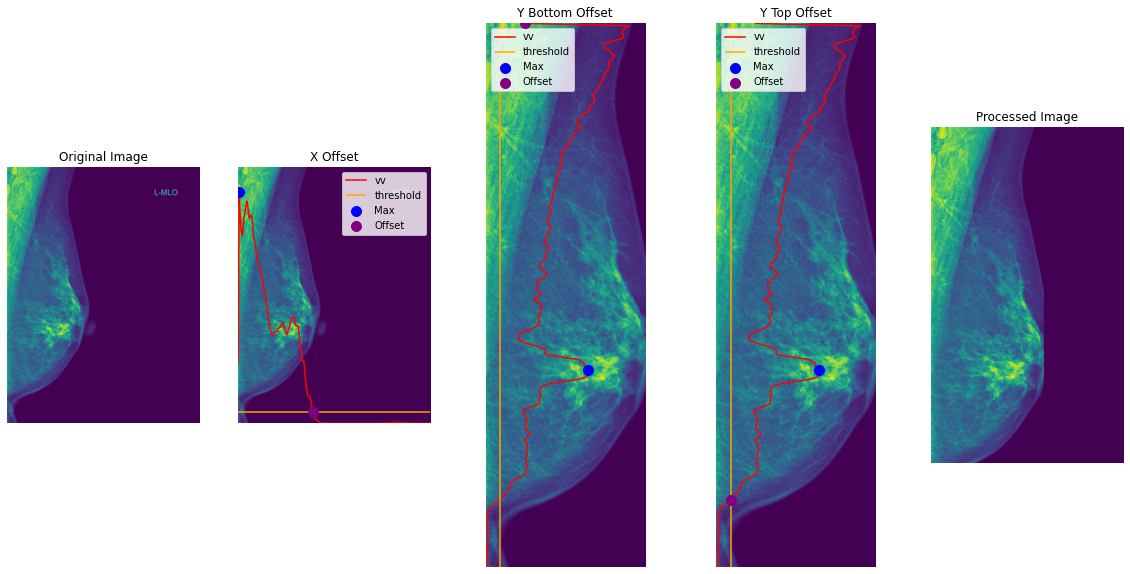

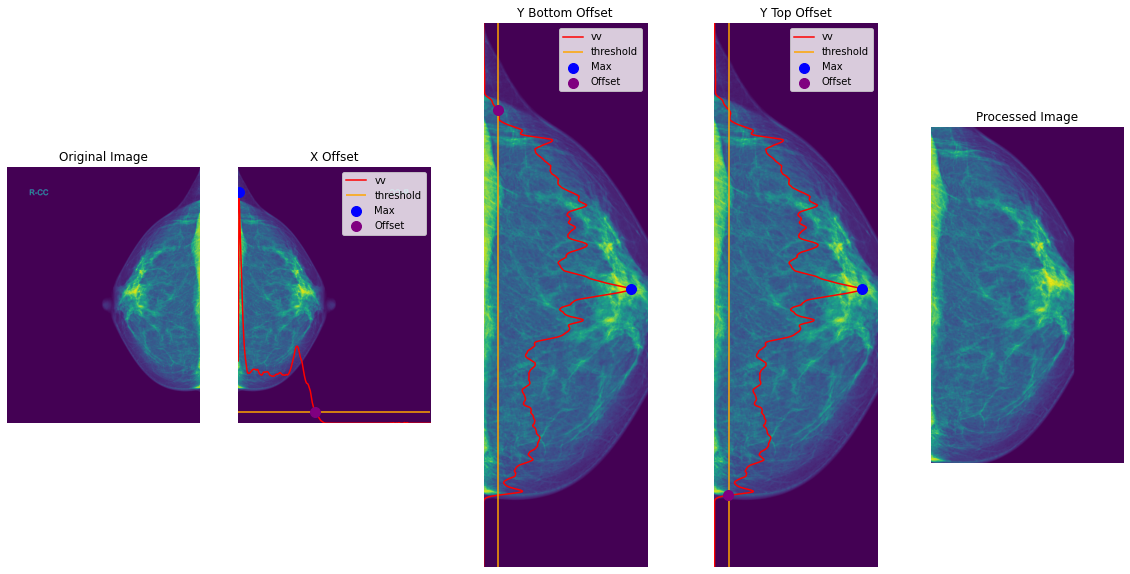

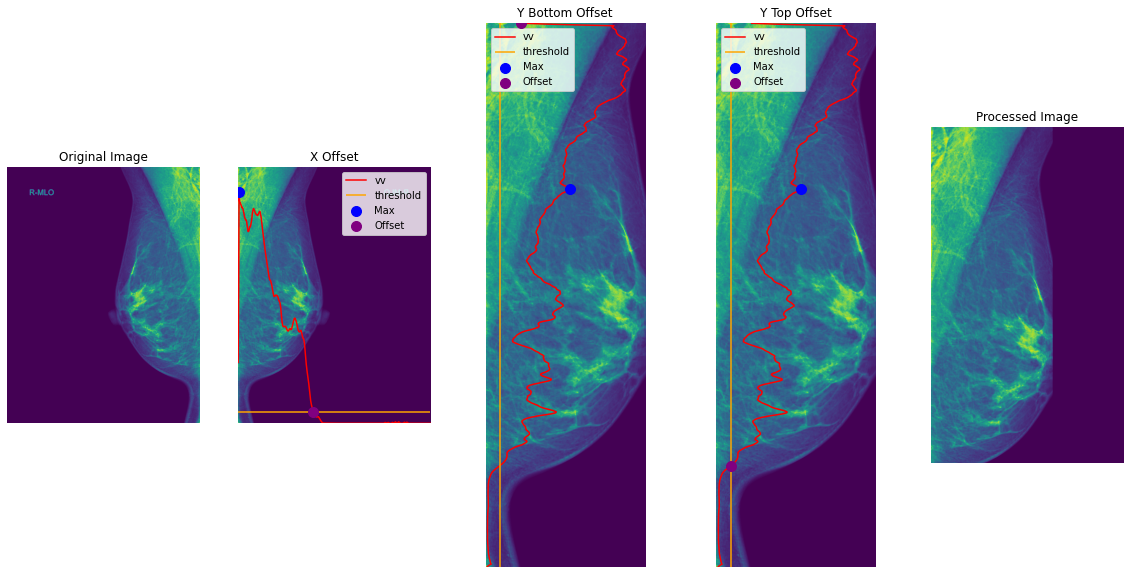

In [9]:
N = 8

for fp in tqdm(train['file_path'].head(N)):
    process(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)

# Model

In [10]:
def normalize(image):
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image

In [11]:
def get_model():
    # Inputs, note the names are equal to the dictionary keys in the dataset
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)

    # Normalize Input
    image_norm = normalize(image)

    # CNN Feature Maps
    x = convnext.ConvNeXtV2Tiny(
        input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3),
        pretrained=None,
        num_classes=0,
    )(image_norm)

    # Average Pooling BxHxWxC -> BxC
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Dropout to prevent Overfitting
    x = tf.keras.layers.Dropout(0.30)(x)
    # Output value between [0, 1] using Sigmoid function
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Define model with inputs and outputs
    model = tf.keras.models.Model(inputs=image, outputs=outputs)

    # Load pretrained Model Weights
    model.load_weights('/kaggle/input/rsna-efficientnetv2-training-tensorflow-tpu-ds/model.h5')

    # Set model non-trainable
    model.trainable = False

    # Compile model
    model.compile()

    return model

In [12]:
# Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
tf.keras.backend.clear_session()
# enable XLA optmizations
tf.config.optimizer.set_jit(True)

model = get_model()

2023-01-26 09:46:10.553872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 09:46:10.695136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 09:46:10.696035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 09:46:10.697395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
# Plot model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 1344, 768, 1)]    0         
_________________________________________________________________
tf.repeat (TFOpLambda)       (None, 1344, 768, None)   0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 1344, 768, None)   0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1344, 768, None)   0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 1344, 768, 3)      0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 1344, 768, 3)      0         
_________________________________________________________________
convnext_v2_tiny (Functional (None, 42, 24, 768)       278649

# Test

In [14]:
test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

def get_file_path(args):
    patient_id, image_id = args
    return f'/kaggle/input/rsna-breast-cancer-detection/test_images/{patient_id}/{image_id}.dcm'
    
test['file_path'] = test[['patient_id', 'image_id']].apply(get_file_path, axis=1)

display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
 9   file_path      4 non-null      object
dtypes: int64(6), object(4)
memory usage: 448.0+ bytes


None

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,file_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/test_images/10008/736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/test_images/10008/1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/test_images/10008/68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/test_images/10008/361203119.dcm


# Sample Submission

In [15]:
sample_submission = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

display(sample_submission.info())
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prediction_id  2 non-null      object 
 1   cancer         2 non-null      float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


None

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


# Parallel Image Processing

In [16]:
# Preprocess a single image and saves it
def preprocess_and_save_image(args):
    (patient_id, laterality), g = args
    cancer = 0.0
    for row_idx, row in g.iterrows():
        process(row['file_path'])

In [17]:
# Preprocess all images in parallel using Joblib
jobs = [joblib.delayed(preprocess_and_save_image)(args) for args in test.groupby(['patient_id', 'laterality'])]
SUBMISSION_ROWS = joblib.Parallel(
    n_jobs=cpu_count(),
    verbose=IS_INTERACTIVE,
    backend='multiprocessing',
    prefer='threads',
)(jobs)

# Inference

  0%|          | 0/2 [00:00<?, ?it/s]

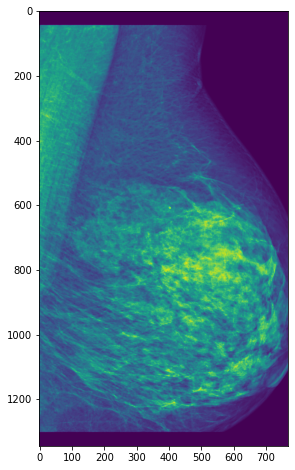

2023-01-26 09:46:22.389655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-26 09:46:23.035976: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x5570027865f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 09:46:23.036042: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-01-26 09:46:23.170559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 09:46:25.630235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-26 09:46:34.647863: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


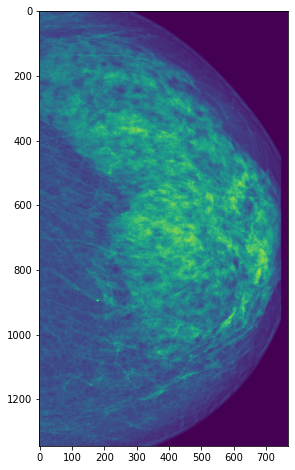

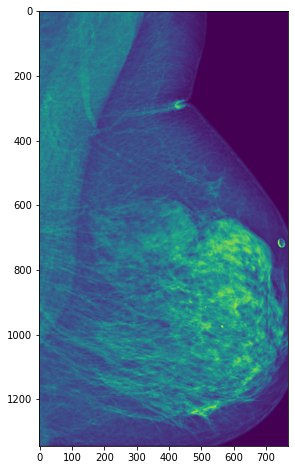

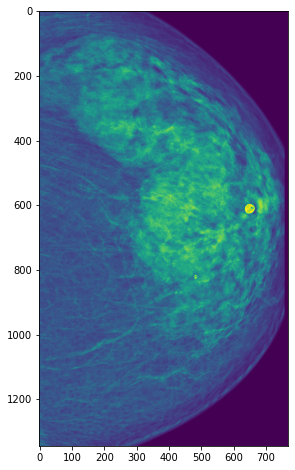

In [18]:
SUBMISSION_ROWS = []
# Iterate over all patient_id/laterality combinations groups
for idx, ((patient_id, laterality), g) in enumerate(tqdm(test.groupby(['patient_id', 'laterality']))):
    # Cancer target is mean of predicted cancer values
    cancer = 0
    # Iterate over all scans in group
    for row_idx, row in g.iterrows():
        # Load Image
        image_id = row['image_id']
        image = cv2.imread(f'{image_id}.{IMAGE_FORMAT}', -1)
        # Show First Few Images
        if idx < 16:
            plt.figure(figsize=(5,8))
            plt.imshow(image)
            plt.show()
        
        # Expand to Batch HxW -> 1xHxWx1
        image = np.expand_dims(image, [0, 3])
        # Make Prediction
        cancer += model.predict_on_batch(image).squeeze() / len(g)
        # Remove Image
        os.remove(f'{image_id}.{IMAGE_FORMAT}')
        
    # Add Submission Row
    SUBMISSION_ROWS.append({
        'prediction_id': f'{patient_id}_{laterality}',
        'cancer': np.int8(cancer > THRESHOLD_BEST),
    })
    
    if np.random.rand() > 0.99:
        gc.collect()

# Save Submission

In [19]:
# Create DataFrame from submission rows
submission_df = pd.DataFrame(SUBMISSION_ROWS)

display(submission_df.info())
display(submission_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   prediction_id  2 non-null      object
 1   cancer         2 non-null      int8  
dtypes: int8(1), object(1)
memory usage: 146.0+ bytes


None

,prediction_id,cancer
0,10008_L,0
1,10008_R,0


In [20]:
# Save submission as CSV
submission_df.to_csv('submission.csv', index=False)

In [21]:
# Sanity Check
display(pd.read_csv('submission.csv').head())

,prediction_id,cancer
0,10008_L,0
1,10008_R,0
